In [73]:
from residual_learning.utils import (
                BaseForecaster, 
                ResidualForecasterDarts,
                TimeSeriesPreprocessor,
                crps
)
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
from darts.metrics import smape, rho_risk
import numpy as np
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("targets.csv.gz")

The different sites are listed below:

In [2]:
targets["site_id"].unique()

array(['ARIK', 'BARC', 'BIGC', 'BLDE', 'BLUE', 'BLWA', 'CARI', 'COMO',
       'CRAM', 'CUPE', 'FLNT', 'GUIL', 'HOPB', 'KING', 'LECO', 'LEWI',
       'LIRO', 'MART', 'MAYF', 'MCDI', 'MCRA', 'OKSR', 'POSE', 'PRIN',
       'PRLA', 'PRPO', 'REDB', 'SUGG', 'SYCA', 'TECR', 'TOMB', 'TOOK',
       'WALK', 'WLOU'], dtype=object)

Loading the csv's

In [3]:
data_preprocessor = TimeSeriesPreprocessor()
data_preprocessor.load()

Let's first look at BARC which has every target series available

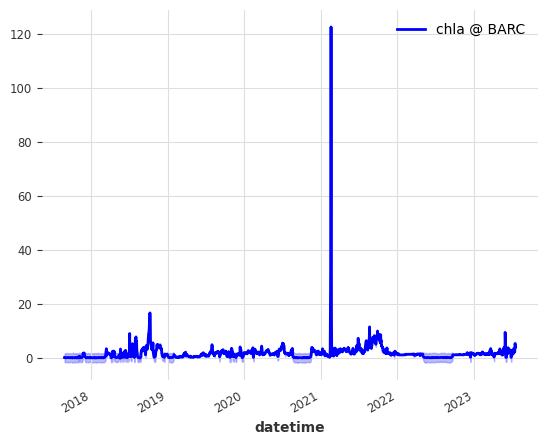

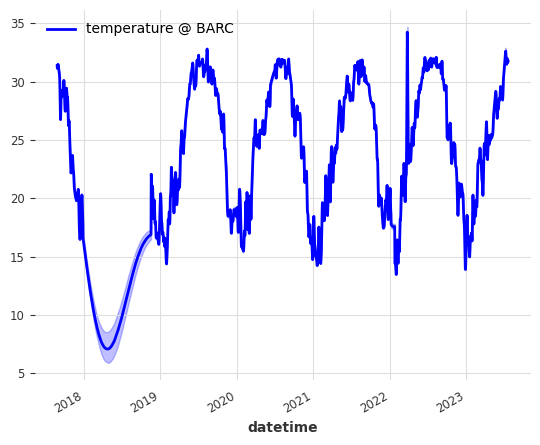

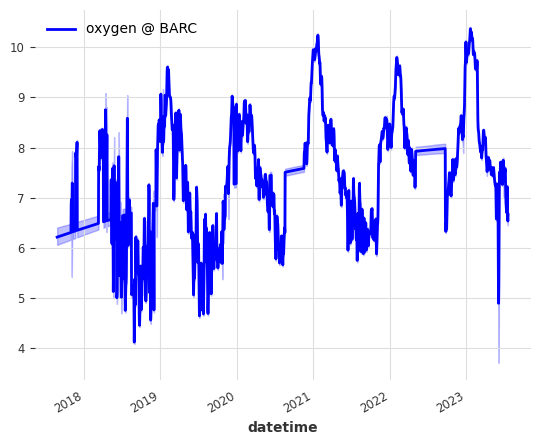

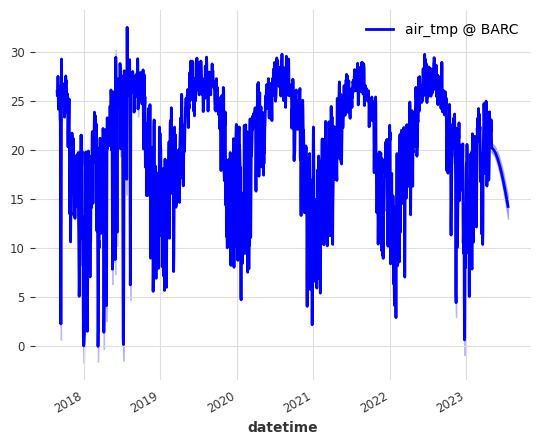

In [4]:
data_preprocessor.plot_by_site("BARC")

After running `python block_rnn.py &` and `python tcn.py &` on command line, let's look at the forecasts. Note this was for oxygen target series at BARC.

Need to make the following class so that it generates samples

In [165]:
class HistoricalForecaster():
    def __init__(self,
                 data_preprocessor: Optional = None,
                 output_csv_name: Optional[str] = "historical_forecaster_output.csv",
                 validation_split_date: Optional[str] = None, #YYYY-MM-DD
                 forecast_horizon: Optional[int] = 30,
                 site_id: Optional[str] = None,
                 target_variable: Optional[str] = None,
                 ):
        self.data_preprocessor = data_preprocessor
        self.output_csv_name = output_csv_name
        self.validation_split_date = validation_split_date
        self.forecast_horizon = forecast_horizon
        self.site_id = site_id
        self.target_variable = target_variable
        self._preprocess_data()

    def _preprocess_data(self):
        stitched_series_dict = self.data_preprocessor.sites_dict[self.site_id]
        # If there was failure when doing the GP fit then we can't do preprocessing
        if self.target_variable in \
                self.data_preprocessor.sites_dict_null[self.site_id]:
            return "Cannot fit this target time series as no GP fit was performed."
        self.inputs = stitched_series_dict[self.target_variable]

        # Splitting training and validation set
        self.year = int(self.validation_split_date[:4])
        month = int(self.validation_split_date[5:7])
        day = int(self.validation_split_date[8:])
        split_date = pd.Timestamp(year=self.year, month=month, day=day)
        self.training_set, self.validation_set = self.inputs.split_before(split_date)

    def make_forecasts(self):
        """
        This function finds the historical mean and var, and uses these statistics for
        the forecast
        """
        # Using the medians of the GP filter
        median_df = data_preprocessor.sites_dict[self.site_id]\
                        [self.target_variable].median().pd_dataframe()
        median_df["timestamp"] = pd.to_datetime(median_df.index)
        median_df["day_of_year"] = median_df["timestamp"].dt.dayofyear
        
        # Computing average and std for doy's 
        doy_df = median_df.groupby(['day_of_year'])['0'].agg(['mean', 'std'])
        
        # Filtering the previously computed averages and std for our dates of interest
        forecast_doys = pd.date_range(start=self.validation_split_date, 
                                      periods=self.forecast_horizon, 
                                      freq='D').dayofyear
        forecast_df = doy_df.loc[forecast_doys]

        # Function to give date from the numerical doy
        def day_of_year_to_date(year, day_of_year):
            base_date = datetime(year, 1, 1)
            target_date = base_date + timedelta(days=day_of_year - 1)
            return target_date

        samples = np.array([np.random.normal(doy_df.loc[doy_df.index == doy]["mean"],
                                    doy_df.loc[doy_df.index == doy]["std"]/2,
                                    size=(1, 500)) for doy in forecast_df.index])

        # Now creating an index going from doy to date
        date_index = [day_of_year_to_date(self.year, day) for day in forecast_df.index]
        forecast_df.index = date_index

        
        self.forecast_df = forecast_df
        self.forecast_ts = TimeSeries.from_times_and_values(forecast_df.index, samples)

    def plot(self):
        fig, ax1 = plt.subplots()
        ax1.plot(self.forecast_df.index, 
                 self.forecast_df["mean"], 
                 label="historical",
                 linewidth=2)
        ax1.fill_between(self.forecast_df.index, 
                         self.forecast_df["mean"] - self.forecast_df["std"], 
                         self.forecast_df["mean"] + self.forecast_df["std"],
                         alpha=0.2,)
        fig.autofmt_xdate()
        plt.legend()

In [166]:
historical_model = HistoricalForecaster(data_preprocessor=data_preprocessor,
                          output_csv_name="historical_forecaster_output.csv",
                          validation_split_date="2023-02-26",
                          forecast_horizon=30,
                          site_id="BARC",
                          target_variable="oxygen")
historical_model.make_forecasts()

Function to create a plot comparing forecast, historical and observed data.

In [173]:
def make_plot(csv_name, site, target_variable, record_dict):
    # Loading the forecast csv and creating a time series
    df = pd.read_csv(f"training_scripts/forecasts/{csv_name}.csv")
    times = pd.to_datetime(df["datetime"])
    times = pd.DatetimeIndex(times)
    values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((len(times), 1, -1))
    model_forecast = TimeSeries.from_times_and_values(times, 
                                                      values, 
                                                      fill_missing_dates=True, freq="D")

    # Presuming data_preprocessor has been called outside of the function
    # (not the best practice), create a validation series from it
    target_series = data_preprocessor.sites_dict[site][target_variable]
    validation_series = target_series.slice(times[0], times[-1]).median()

    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(data_preprocessor=data_preprocessor,
                          output_csv_name="historical_forecaster_output.csv",
                          validation_split_date=str(model_forecast.time_index[0])[:10],
                          forecast_horizon=30,
                          site_id=site,
                          target_variable=target_variable)
    historical_model.make_forecasts()
    
    if site not in record_dict.keys():
        record_dict[site] = {target_variable: {csv_name: model_forecast}}
        record_dict[site][target_variable]["validation"] = validation_series
        # I need to make draw samples from historical would be best to just do this in utils
        record_dict[site][target_variable]["historical"] = historical_model.forecast_df
    else:
        record_dict[site][target_variable][csv_name] = model_forecast    
    
    validation_series.plot(label="Truth")
    model_forecast.plot(label="Forecast")
    historical_model.forecast_ts.plot(label="historical")

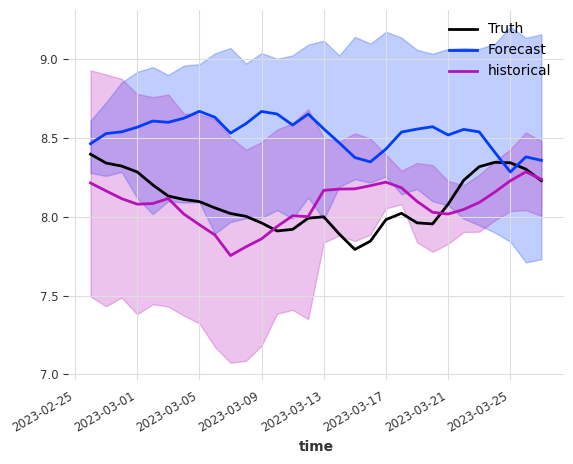

In [174]:
make_plot("block_rnn", "BARC", "oxygen", forecasts_dict)

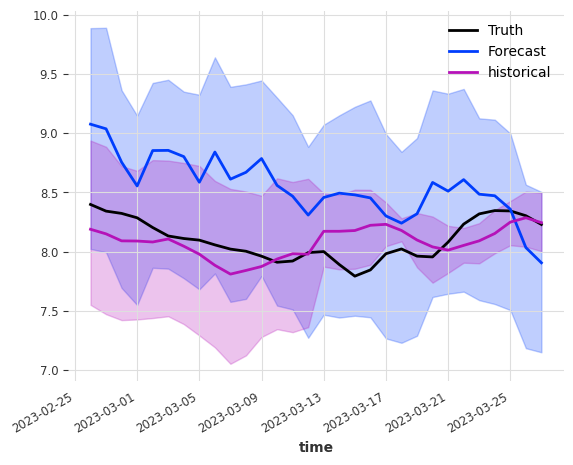

In [175]:
make_plot("tcn", "BARC", "oxygen", forecasts_dict)

Ok let's compare SMAPE and CRPS, first with CRPS.

In [96]:
block_crps = crps(forecasts_dict["BARC"]["oxygen"]["block_rnn"], forecasts_dict["BARC"]["oxygen"]["validation"])
tcn_crps = crps(forecasts_dict["BARC"]["oxygen"]["tcn"], forecasts_dict["BARC"]["oxygen"]["validation"])

Not the best plot selection here but going with it. Jitter plot in SNS way better.

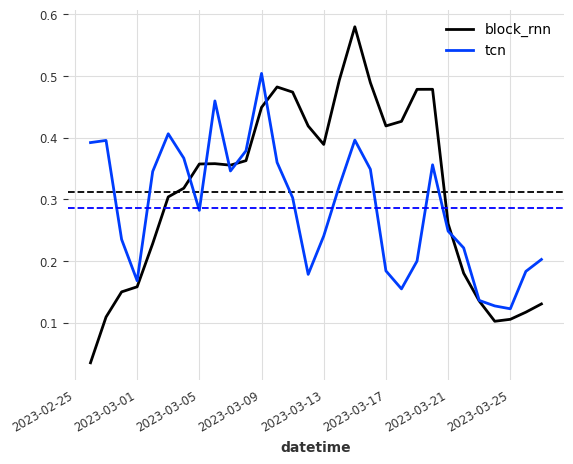

In [97]:
plt.clf()
block_crps.plot(label = "block_rnn")
plt.axhline(y = block_crps.mean(axis=0).values()[0][0], color = 'black', linestyle = '--')
tcn_crps.plot(label = "tcn")
plt.axhline(y = tcn_crps.mean(axis=0).values()[0][0], color = 'blue', linestyle = '--')
plt.show()

And, now with SMAPE

In [98]:
block_smapes = smape(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"], 
                     n_jobs=-1, 
                     verbose=False)

tcn_smapes = smape(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     n_jobs=-1, 
                     verbose=False)

In [99]:
block_smapes, tcn_smapes

(5.18028470325917, 5.826564064041284)

And, with rho risk

In [103]:
block_rho_50 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"],
                     rho=0.5,
                     verbose=False)

tcn_rho_50 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     rho=0.5,
                     verbose=False)

block_rho_05 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"],
                     rho=0.05,
                     verbose=False)

tcn_rho_05 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     rho=0.05,
                     verbose=False)

block_rho_95 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"],
                     rho=0.95,
                     verbose=False)

tcn_rho_95 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     rho=0.95,
                     verbose=False)

In [104]:
block_rho_05, tcn_rho_05

(0.08126538384662846, 0.053911427992865184)

In [102]:
block_rho_50, tcn_rho_50

(0.0533452282821601, 0.04693386112683963)

In [105]:
block_rho_95, tcn_rho_95

(0.0064216792762933515, 0.006512460441479214)